# Stock Trading Example

This notebook demonstrates using the TimeSeries Agent for stock trading, showing:

1. Working with financial data
2. Feature engineering for market indicators
3. Training an RL agent for directional prediction (Up/Down/Same)
4. Real-time trading signals

In [1]:
!pip install python-dotenv --quiet

In [2]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
from dotenv import load_dotenv
load_dotenv()  # Load .env file
from timeseries_agent.api import train_from_csv
import warnings
warnings.filterwarnings("ignore")

## 1. Get Stock Data

In [3]:
def add_features(df, col_names_dict):
    """Add technical indicators as features."""
    df = df.copy()
    
    # Drop date column
    df = df.reset_index(drop=True)
    df.drop(columns=col_names_dict['Date'], inplace=True)
    
    # Price features
    df['returns'] = df[col_names_dict['Close']].pct_change()
    df['log_returns'] = np.log1p(df['returns'])
    
    # Moving averages
    df['sma_20'] = df[col_names_dict['Close']].rolling(20).mean()
    df['sma_50'] = df[col_names_dict['Close']].rolling(50).mean()
    df['sma_ratio'] = df['sma_20'] / df['sma_50']
    
    # Volatility
    df['volatility'] = df['returns'].rolling(20).std()
    
    # Volume features
    volume_ma = df[col_names_dict['Volume']].rolling(20).mean()
    df['volume_ratio'] = df[col_names_dict['Volume']].div(volume_ma)
    
    return df.dropna().reset_index(drop=True)

In [4]:
# Load your FMP API key
api_key = os.environ.get("FMP_API_KEY")
# Symbol to fetch historical data 
symbol = "EURUSD"
interval = "15min"  # Options: '1min', '5min', '15min', '30min', '1hour', '4hour', '1day', '1week', '1month'

# Define the endpoint for historical stock data for NVIDIA
url = f'https://financialmodelingprep.com/api/v3/historical-chart/{interval}/{symbol}?apikey={api_key}'

# Fetch the data from FMP API
response = requests.get(url)
data = response.json()

# Convert the historical data into a pandas DataFrame
data = pd.DataFrame(data)
display(data.head())
display(data.tail())

,date,open,low,high,close,volume
0,2025-07-18 01:15:00,1.16182,1.16157,1.16225,1.16158,654
1,2025-07-18 01:00:00,1.16185,1.16177,1.16239,1.16187,1175
2,2025-07-18 00:45:00,1.16189,1.16183,1.16252,1.16193,1076
3,2025-07-18 00:30:00,1.16198,1.16185,1.16239,1.16188,710
4,2025-07-18 00:15:00,1.16205,1.16191,1.16239,1.16239,855


,date,open,low,high,close,volume
3546,2025-05-28 01:00:00,1.13058,1.13013,1.13062,1.13017,1838
3547,2025-05-28 00:45:00,1.13065,1.13045,1.13080,1.13058,1738
3548,2025-05-28 00:30:00,1.13039,1.13031,1.13074,1.13065,1568
3549,2025-05-28 00:15:00,1.13045,1.13023,1.13062,1.13039,1656
3550,2025-05-28 00:00:00,1.13070,1.13029,1.13102,1.13045,1954


In [5]:
# Reverse the DataFrame to have the most recent data at the top
data = data.iloc[::-1].reset_index(drop=True)
display(data.head())
display(data.tail())

,date,open,low,high,close,volume
0,2025-05-28 00:00:00,1.13070,1.13029,1.13102,1.13045,1954
1,2025-05-28 00:15:00,1.13045,1.13023,1.13062,1.13039,1656
2,2025-05-28 00:30:00,1.13039,1.13031,1.13074,1.13065,1568
3,2025-05-28 00:45:00,1.13065,1.13045,1.13080,1.13058,1738
4,2025-05-28 01:00:00,1.13058,1.13013,1.13062,1.13017,1838


,date,open,low,high,close,volume
3546,2025-07-18 00:15:00,1.16205,1.16191,1.16239,1.16239,855
3547,2025-07-18 00:30:00,1.16198,1.16185,1.16239,1.16188,710
3548,2025-07-18 00:45:00,1.16189,1.16183,1.16252,1.16193,1076
3549,2025-07-18 01:00:00,1.16185,1.16177,1.16239,1.16187,1175
3550,2025-07-18 01:15:00,1.16182,1.16157,1.16225,1.16158,654


### 1.a. Add Features Columns

In [6]:
col_names_dict = {
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}
# Add technical indicators as features
df = add_features(data, col_names_dict)

target_column = 'close'                 # Target column for price prediction
df = df.head(1000)                      # Limit to the first 1000 rows for training
# Save test data except the last n rows
last_n_test_rows = 100
train_data = df.iloc[:-last_n_test_rows]
test_data = df.tail(last_n_test_rows)


# Save train data
print(f"Train Shape: {train_data.shape}, Test Shape: {test_data.shape}")
display(train_data.head())
display(test_data.head())

Train Shape: (900, 12), Test Shape: (100, 12)


,open,low,high,close,volume,returns,log_returns,sma_20,sma_50,sma_ratio,volatility,volume_ratio
0,1.12933,1.12926,1.12964,1.12950,2544,0.000151,0.000151,1.130567,1.131375,0.999286,0.000599,0.467123
1,1.12950,1.12907,1.12959,1.12933,2479,-0.000151,-0.000151,1.130409,1.131352,0.999166,0.000595,0.460631
2,1.12933,1.12903,1.12941,1.12936,2240,0.000027,0.000027,1.130291,1.131332,0.999080,0.000583,0.427065
3,1.12936,1.12921,1.12963,1.12959,2569,0.000204,0.000204,1.130211,1.131310,0.999028,0.000580,0.498893
4,1.12959,1.12943,1.13002,1.12968,2186,0.000080,0.000080,1.130133,1.131292,0.998975,0.000580,0.430599


,open,low,high,close,volume,returns,log_returns,sma_20,sma_50,sma_ratio,volatility,volume_ratio
900,1.14192,1.14057,1.14201,1.14082,2896,-0.000963,-0.000964,1.142589,1.142538,1.000045,0.000363,1.581563
901,1.14082,1.14069,1.14127,1.14113,2817,0.000272,0.000272,1.142528,1.142476,1.000046,0.000363,1.431657
902,1.14113,1.14106,1.14144,1.14122,1784,0.000079,0.000079,1.142475,1.142415,1.000053,0.000364,0.870201
903,1.14122,1.14121,1.14173,1.14163,1857,0.000359,0.000359,1.142443,1.142384,1.000052,0.000375,0.889922
904,1.14163,1.14137,1.14176,1.14152,1415,-0.000096,-0.000096,1.142403,1.142351,1.000045,0.000375,0.676532


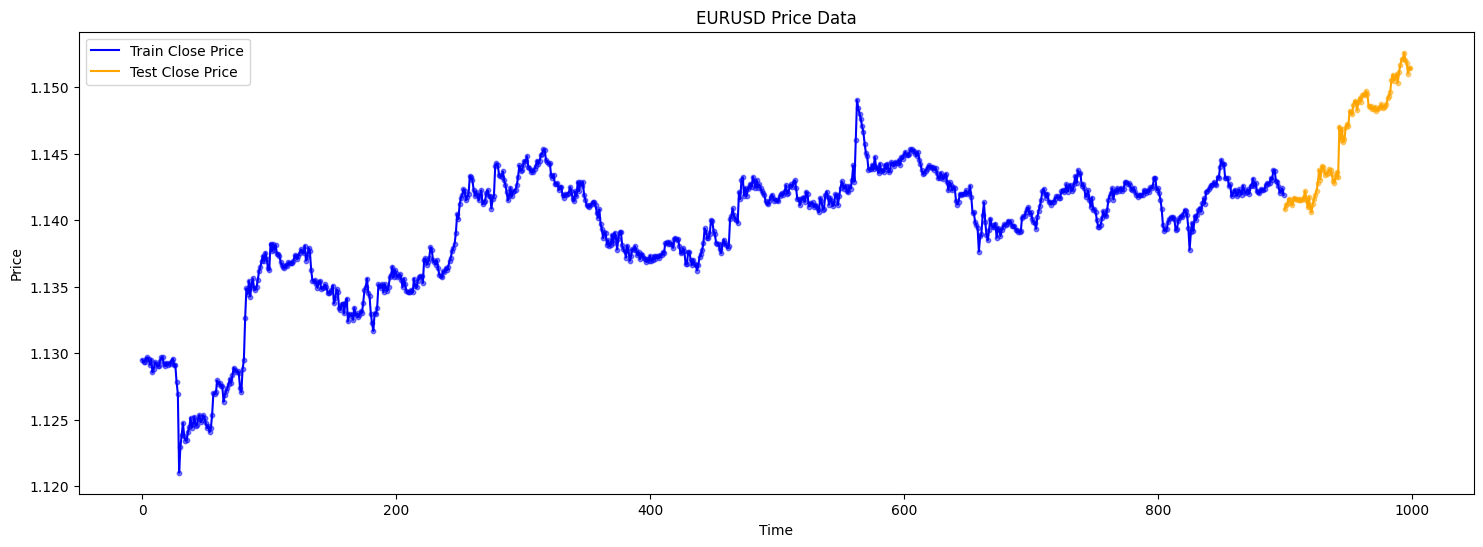

In [7]:
# Plot stock price/train and test data
plt.figure(figsize=(18, 6))
plt.plot(train_data.index, train_data['close'], color='blue', label='Train Close Price')
plt.plot(test_data.index, test_data['close'], color='orange', label='Test Close Price')
plt.scatter(train_data.index, train_data['close'], color='blue', s=10, alpha=0.5)
plt.scatter(test_data.index, test_data['close'], color='orange', s=10, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f"{symbol} Price Data")
plt.legend()
plt.show()

### 1.b. Compute Target Direction Distribution

In [8]:
# Compute distribution of directions
train_target_diff = train_data[target_column].diff()
train_directions = train_target_diff.apply(lambda x: 0 if x > 0 else 1 if x < 0 else 2).iloc[1:]
train_directions_counts = Counter(train_directions)
print("Train Directions Counts:", train_directions_counts)

test_target_diff = test_data[target_column].diff()
test_directions = test_target_diff.apply(lambda x: 0 if x > 0 else 1 if x < 0 else 2).iloc[1:]
test_directions_counts = Counter(test_directions)
print("Test Directions Counts:", test_directions_counts)

Train Directions Counts: Counter({0: 456, 1: 437, 2: 6})
Test Directions Counts: Counter({0: 57, 1: 42})


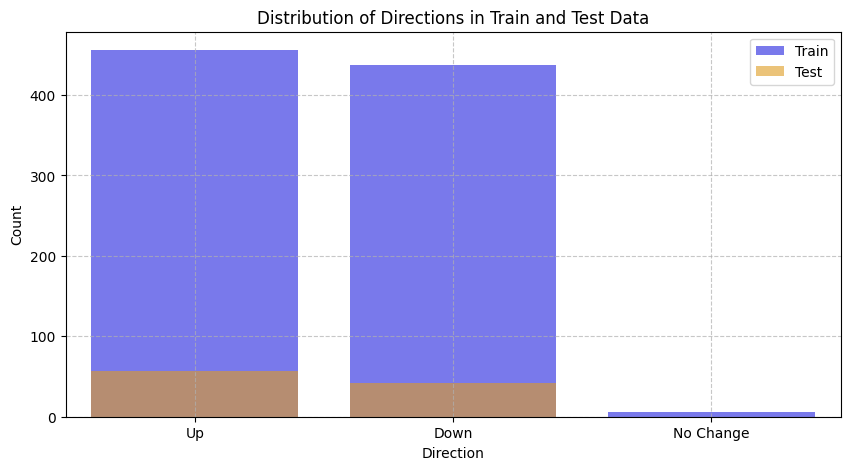

In [9]:
# Create the a bar plot for the distribution of directions
plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_directions_counts.keys()), y=list(train_directions_counts.values()), color='blue', alpha=0.6, label='Train')
sns.barplot(x=list(test_directions_counts.keys()), y=list(test_directions_counts.values()), color='orange', alpha=0.6, label='Test')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.title('Distribution of Directions in Train and Test Data')
plt.xticks([0, 1, 2], ['Up', 'Down', 'No Change'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [10]:
# Save the training and testing data to CSV files
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
train_csv_path = os.path.join(DATA_DIR, 'fin_train.csv')
test_csv_path = os.path.join(DATA_DIR, 'fin_test.csv')

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

## 2. Configure Reward Strategy

The agent automatically calculates rewards during training based on:
- Action 0: Predict price will go Up
- Action 1: Predict price will go Down  
- Action 2: Predict price will stay Same

Reward is +1 for correct predictions, -1 for incorrect

In [11]:
reward_config = {
    'method': 'proportional',
    'scale': 100.0,                # Amplify small returns
    'min_change_pct': 0.001        # Min 0.1% move for reward. This helps avoid noise and serves as a bid/ask spread filter
}

## 3. Train Agent

In [12]:
# Define feature columns
feature_cols = [
    'returns', 'sma_ratio', 'volatility',
    'volume_ratio', 'log_returns'
    ] + [target_column]

# Define environment kwargs
lookback = 10
env_kwargs = {
        'lookback': lookback,
        'normalize_state': True,
        'test_size': 0.2                    # Use 20% of data for validation
    }

# Define agent kwargs 
agent_type = 'ppo'                          # options: 'ppo', 'reinforce', and 'reinforce_step'
agent_kwargs = {
        'hidden_layers': [64, 32],          # More complex architecture for better learning
        'output_size': 3,                   # Three possible actions: Up, Down, Same
        'agent_type': agent_type,  
    }

# Define trainer kwargs
trainer_kwargs = {
        'max_epochs': 100,
        'enable_checkpointing': True,
        'experiment_name': f'{symbol}_trading'
    }

# Train with automatic action sampling and reward generation
agent = train_from_csv(
    csv_path=train_csv_path,
    feature_cols=feature_cols,
    target_col=target_column,
    reward_config=reward_config,
    env_kwargs=env_kwargs,
    agent_kwargs=agent_kwargs,
    trainer_kwargs=trainer_kwargs
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 6.1 K  | train
2 | value_net     | Sequential | 6.0 K  | train
-----------------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Using reward config: {'method': 'proportional', 'scale': 100.0, 'min_change_pct': 0.001}
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3550295829772949     │
│          val_f1           │    0.4108504354953766     │
│       val_precision       │    0.5027544498443604     │
│        val_recall         │    0.3550295829772949     │
│        val_reward         │  -0.0004914449527859688   │
│         val_steps         │           169.0           │
└───────────────────────────┴───────────────────────────┘

### 3.a. Plot Training Logs

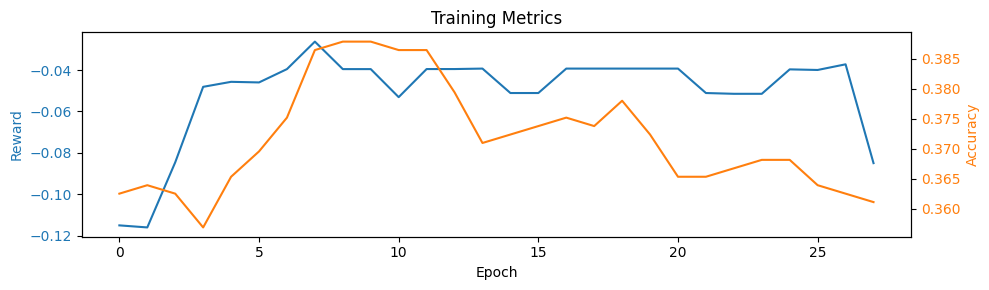

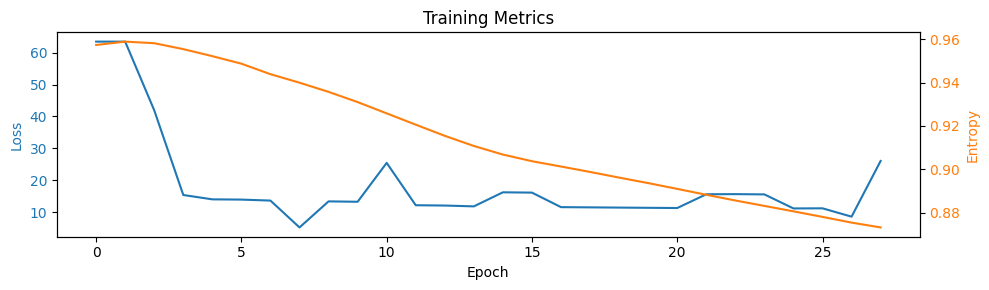

In [13]:
from timeseries_agent.utils.extras import plot_training_metrics
plot_training_metrics(agent)

## 4. Evaluate Agent
The agent predicts market direction (Up/Down/Same) based on recent data

In [14]:
from timeseries_agent.api import load_agent

In [15]:
log_dir = agent.trainer.logger.log_dir
checkpoint_path = os.path.join(log_dir, 'checkpoints', 'last.ckpt')
print(checkpoint_path)

logs\EURUSD_trading\version_0\checkpoints\last.ckpt


In [16]:
# Load the trained agent
loaded_agent = load_agent(
    checkpoint_path=checkpoint_path,
    csv_path=test_csv_path,
    feature_cols=feature_cols,
    target_col=target_column,
    agent_type=agent_type,              # Specify the agent type
    **env_kwargs                        # Pass the same environment configuration used during training
)

In [17]:
def get_profit_loss(current_val, next_val, true_action, pred_action):
    """
    Calculate the profit or loss based on price change and action taken,
    considering pip_value as the cost of trade.
    """
    pip_value = 0.0001  # For forex pairs like AUDUSD, pip value is typically 0.0001
    diff = (next_val - current_val)
    profit_loss = 0.0

    if pred_action == 2:
        # No action taken, return 0
        profit_loss = 0.0
    elif true_action == pred_action:
        # Correct prediction
        if abs(diff) > 0:
            profit_loss = abs(diff) - pip_value # abs(diff) because the action was correct and we want profit
    return profit_loss

In [18]:
def get_true_action(current_val, next_val):
    true_action = 0 if next_val > current_val else 1 if next_val < current_val else 2
    return true_action

# Batch predictions on historical data
def get_batch_predictions(df, lookback_size):
    predictions = []
    true_actions = []
    total_profit = 0.0
    for i in range(lookback_size, len(df)):
        if i >= len(df) - 1:
            continue
        current_features = df[feature_cols].iloc[i-lookback_size:i].values.astype(np.float32)
        current_target = df[target_column].iloc[i]
        pred_action, probs = loaded_agent.act(current_features, return_probs=True)
        predictions.append(pred_action)
        next_target = df[target_column].iloc[i+1]
        true_action = get_true_action(current_target, next_target)
        pl = get_profit_loss(current_target, next_target, true_action, pred_action)
        total_profit += pl
        message = f'Profit={pl:.4f}' if pl > 0 else f'Loss={pl:.4f}'
        print(f'True={true_action} -- Pred={pred_action} -- Prob={probs} -- {message}')
        true_actions.append(true_action)
        
    return true_actions, predictions, total_profit

# Get predictions
df = pd.read_csv(test_csv_path)
y_true, y_pred, total_profit = get_batch_predictions(df[:], lookback)

print(f'\n true dist == {Counter(y_true)}, pred dist == {Counter(y_pred)}')
print(f'Total Profit/Loss: {total_profit:.4f} pips')  

True=0 -- Pred=0 -- Prob=[0.6245991  0.13671622 0.23868465] -- Loss=-0.0000
True=1 -- Pred=2 -- Prob=[0.39134932 0.1716341  0.43701655] -- Loss=0.0000
True=1 -- Pred=0 -- Prob=[0.52426225 0.30143836 0.17429943] -- Loss=0.0000
True=0 -- Pred=2 -- Prob=[0.31693438 0.12879206 0.5542736 ] -- Loss=0.0000
True=0 -- Pred=1 -- Prob=[0.06542354 0.8778687  0.05670765] -- Loss=0.0000
True=0 -- Pred=0 -- Prob=[0.55655277 0.30068672 0.14276049] -- Profit=0.0004
True=1 -- Pred=0 -- Prob=[0.67207354 0.08897338 0.23895314] -- Loss=0.0000
True=1 -- Pred=2 -- Prob=[0.24032633 0.35727778 0.40239584] -- Loss=0.0000
True=0 -- Pred=2 -- Prob=[0.18811287 0.18542536 0.6264618 ] -- Loss=0.0000
True=1 -- Pred=2 -- Prob=[0.2564148  0.17715631 0.5664289 ] -- Loss=0.0000
True=1 -- Pred=2 -- Prob=[0.25572652 0.20729999 0.53697354] -- Loss=0.0000
True=0 -- Pred=1 -- Prob=[0.3817954  0.40491924 0.21328536] -- Loss=0.0000
True=0 -- Pred=0 -- Prob=[0.6486875  0.10298382 0.24832869] -- Profit=0.0003
True=0 -- Pred=0 -- 

### 4.a. Visualize Agents Evaluation Metrics

In [19]:
from timeseries_agent.utils.extras import plot_prediction_density, plot_confusion_matrix_n_metrics

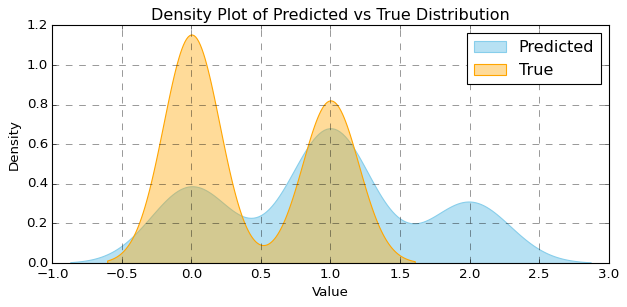

In [20]:
plot_prediction_density(y_true, y_pred)

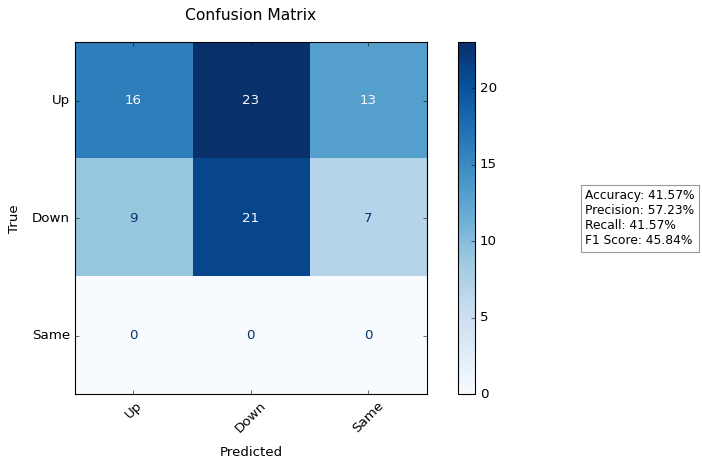

In [21]:
plot_confusion_matrix_n_metrics(y_true, y_pred)